In [1]:
import math
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import statsmodels.api as sm

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('ggplot')
font_size = 14
plt.rcParams.update({'font.size': font_size})

/home/asa/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_usa_rates = pd.read_csv('../data/us_states_covid19_daily.csv')
df_usa_rates.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200510,AK,379.0,26985.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,27364,27364,27364,2,0.0,0.0,914.0,1.0,915.0
1,20200510,AL,9777.0,117644.0,NaN,NaN,1240.0,NaN,460.0,NaN,...,1240.0,127421,127421,127421,1,5.0,12.0,1717.0,210.0,1927.0
2,20200510,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,...,471.0,65528,65528,65528,5,0.0,0.0,0.0,0.0,0.0
3,20200510,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83,83,83,60,0.0,0.0,0.0,0.0,0.0
4,20200510,AZ,11119.0,126620.0,NaN,713.0,1528.0,300.0,NaN,195.0,...,1528.0,137739,137739,137739,4,4.0,14.0,8640.0,159.0,8799.0


In [35]:
df_usa_rates['datetime'] = pd.to_datetime(df_usa_rates['date'].astype(str), format='%Y%m%d')
df_usa_rates['d_o_y'] = pd.DatetimeIndex(df_usa_rates['datetime']).dayofyear
df_usa_rates.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y
0,20200510,AK,379.0,26985.0,NaN,8.0,NaN,NaN,NaN,NaN,...,27364,27364,2,0.0,0.0,914.0,1.0,915.0,2020-05-10,131
1,20200510,AL,9777.0,117644.0,NaN,NaN,1240.0,NaN,460.0,NaN,...,127421,127421,1,5.0,12.0,1717.0,210.0,1927.0,2020-05-10,131
2,20200510,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,...,65528,65528,5,0.0,0.0,0.0,0.0,0.0,2020-05-10,131
3,20200510,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,83,83,60,0.0,0.0,0.0,0.0,0.0,2020-05-10,131
4,20200510,AZ,11119.0,126620.0,NaN,713.0,1528.0,300.0,NaN,195.0,...,137739,137739,4,4.0,14.0,8640.0,159.0,8799.0,2020-05-10,131


In [37]:
type(df_usa_rates['d_o_y'][0])

numpy.int64

In [10]:
state = 'NY'
df2 = df_usa_rates[df_usa_rates['state']==state]
df2.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y
37,20200510,NY,335395.0,847603.0,NaN,7262.0,72715.0,2488.0,NaN,2073.0,...,1182998,1182998,36,207.0,460.0,26957.0,2273.0,29230.0,2020-05-10,131
93,20200509,NY,333122.0,820646.0,NaN,7776.0,72255.0,2664.0,NaN,2203.0,...,1153768,1153768,36,226.0,576.0,29510.0,2715.0,32225.0,2020-05-09,130
149,20200508,NY,330407.0,791136.0,NaN,8196.0,71679.0,2811.0,NaN,2295.0,...,1121543,1121543,36,217.0,527.0,28869.0,2758.0,31627.0,2020-05-08,129
205,20200507,NY,327649.0,762267.0,NaN,8665.0,71152.0,2976.0,NaN,2425.0,...,1089916,1089916,36,951.0,613.0,30324.0,3671.0,33995.0,2020-05-07,128
261,20200506,NY,323978.0,731943.0,NaN,9179.0,70539.0,NaN,NaN,NaN,...,1055921,1055921,36,232.0,672.0,24236.0,2786.0,27022.0,2020-05-06,127


In [44]:
df2[-1:]

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y
3658,20200304,NY,6.0,48.0,24.0,NaN,NaN,NaN,NaN,NaN,...,54,54,36,NaN,NaN,NaN,NaN,NaN,2020-03-04,64


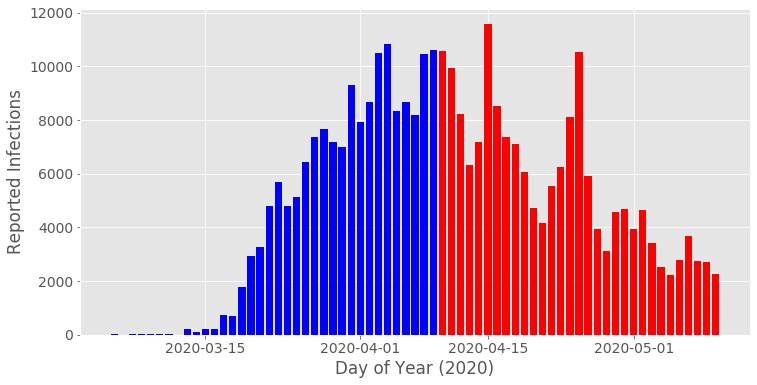

In [32]:
fig, ax = plt.subplots(figsize = (12,6))

mask1 = df2['d_o_y'] <= 100
mask2 = df2['d_o_y'] > 100

ax.bar(df2['datetime'][mask1], df2['positiveIncrease'][mask1], label = f"{state}",color='b')
ax.bar(df2['datetime'][mask2], df2['positiveIncrease'][mask2], label = f"{state}",color='r')
# ax.legend(loc='upper left')

# ax.xaxis.set_major_locator(MultipleLocator(5))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_xlabel('Day of Year (2020)') 
ax.set_ylabel('Reported Infections')

# ax.label_outer()
# plt.suptitle('Infection Counts By Day of Year, By State', fontsize=16, y = 0.95)
plt.show();

In [46]:
num_days_smooth = 7
df2[f'Rolling-{num_days_smooth}mean'] = df2['positiveIncrease'].rolling(window=num_days_smooth, center = True).mean()
# df2[f'Rolling-{num_days_smooth}mean'].fillna(value=0, inplace=True)
df2.head()

/home/asa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y,Rolling-7mean
37,20200510,NY,335395.0,847603.0,NaN,7262.0,72715.0,2488.0,NaN,2073.0,...,1182998,36,207.0,460.0,26957.0,2273.0,29230.0,2020-05-10,131,NaN
93,20200509,NY,333122.0,820646.0,NaN,7776.0,72255.0,2664.0,NaN,2203.0,...,1153768,36,226.0,576.0,29510.0,2715.0,32225.0,2020-05-09,130,NaN
149,20200508,NY,330407.0,791136.0,NaN,8196.0,71679.0,2811.0,NaN,2295.0,...,1121543,36,217.0,527.0,28869.0,2758.0,31627.0,2020-05-08,129,NaN
205,20200507,NY,327649.0,762267.0,NaN,8665.0,71152.0,2976.0,NaN,2425.0,...,1089916,36,951.0,613.0,30324.0,3671.0,33995.0,2020-05-07,128,2711.428571
261,20200506,NY,323978.0,731943.0,NaN,9179.0,70539.0,NaN,NaN,NaN,...,1055921,36,232.0,672.0,24236.0,2786.0,27022.0,2020-05-06,127,2877.857143


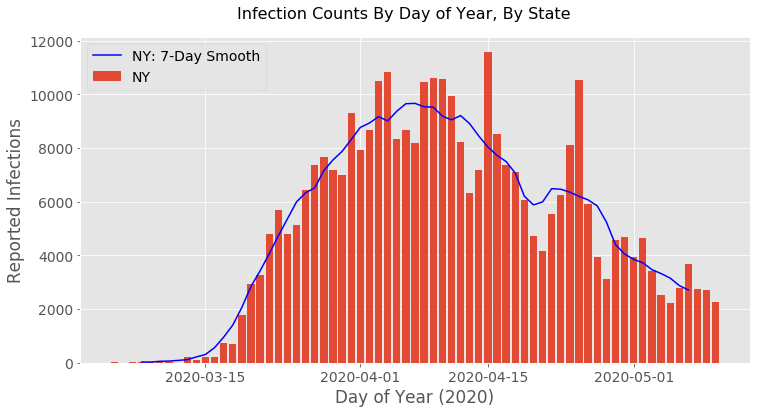

In [47]:
fig, ax = plt.subplots(figsize = (12,6))

ax.bar(df2.datetime, df2['positiveIncrease'], label = f"{state}")
plt.plot(df2.datetime, df2[f'Rolling-{num_days_smooth}mean'], 
         label = f"{state}: {num_days_smooth}-Day Smooth", color='blue')
ax.legend(loc='upper left')
ax.set_xlabel('Day of Year (2020)') 
ax.set_ylabel('Reported Infections') 
ax.label_outer()
plt.suptitle('Infection Counts By Day of Year, By State', fontsize=16, y = 0.95)
plt.show();

In [48]:
df2.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y,Rolling-7mean
37,20200510,NY,335395.0,847603.0,NaN,7262.0,72715.0,2488.0,NaN,2073.0,...,1182998,36,207.0,460.0,26957.0,2273.0,29230.0,2020-05-10,131,NaN
93,20200509,NY,333122.0,820646.0,NaN,7776.0,72255.0,2664.0,NaN,2203.0,...,1153768,36,226.0,576.0,29510.0,2715.0,32225.0,2020-05-09,130,NaN
149,20200508,NY,330407.0,791136.0,NaN,8196.0,71679.0,2811.0,NaN,2295.0,...,1121543,36,217.0,527.0,28869.0,2758.0,31627.0,2020-05-08,129,NaN
205,20200507,NY,327649.0,762267.0,NaN,8665.0,71152.0,2976.0,NaN,2425.0,...,1089916,36,951.0,613.0,30324.0,3671.0,33995.0,2020-05-07,128,2711.428571
261,20200506,NY,323978.0,731943.0,NaN,9179.0,70539.0,NaN,NaN,NaN,...,1055921,36,232.0,672.0,24236.0,2786.0,27022.0,2020-05-06,127,2877.857143


In [ ]:
def open_merge_files(infection_file_path, df_population):
    df_usa_rates = pd.read_csv(infection_file_path)
    df_usa_rates['datetime'] = pd.to_datetime(df_usa_rates['date'].astype(str), format='%Y%m%d')
    df_usa_rates['d_o_y'] = pd.DatetimeIndex(df_usa_rates['datetime']).dayofyear
    
    df_usa = pd.merge(df_usa_rates, df_population, how='outer', left_on='state', right_on='ABBR',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)[['datetime','d_o_y','NAME', 'state', 'POPESTIMATE2019','positiveIncrease', 
                         'positive', 'negativeIncrease', 'negative', 'pending', 'deathIncrease', 'death', 'recovered', 
                         'hospitalizedIncrease','hospitalized','totalTestResultsIncrease',
                         'totalTestResults','posNeg','total']]
    df_usa.columns = ['datetime','d_o_y','state_name', 'state_id', 'state_pop_2019','positive_daily_incr', 
                  'positive_cum', 'negative_daily_incr', 'negative_cum', 'pending_daily','death_daily_incr', 
                  'death_cum', 'recovered_cum', 'hospitalized_daily_incr','hospitalized_cum',
                  'total_test_results_daily_incr','total_test_results_cum','test_pos_neg_cum','total_tests_cum']
    return df_usa

In [ ]:
df_usa_pop = pd.read_csv('../data/us_state_population_2019.csv')

In [ ]:
df_usa = open_merge_files('../data/us_states_covid19_daily.csv', df_usa_pop)

In [ ]:
df_usa

In [ ]:
df_usa['d_o_y'].dropna(inplace =True)
df_usa.astype({'d_o_y' : int})
df_usa.head()

In [ ]:
type(df_usa.d_o_y[0])
print(df_usa.dtypes) 

In [ ]:
metric_dict = {'infection' : ['positive_daily_incr', 'Infections', 'Infection Counts', 'infection_counts'],
                   'hospitalized' : ['hospitalized_daily_incr', 'Hospitializations', 'Hospitializations', 'hospitializations'],
                   'death' : ['death_daily_incr', 'Deaths', 'Deaths', 'deaths']}

In [ ]:
metric_dict['infection'][3]

In [ ]:
def plot_infection_trends(state_list, metric = 'infection'):
    num_days_smooth = 7
    metric_dict = {'infection' : ['positive_daily_incr', 'Infections', 'Infection Counts', 'infection_counts'],
                   'hospitalized' : ['hospitalized_daily_incr', 'Hospitializations', 'Hospitializations', 'hospitializations'],
                   'death' : ['death_daily_incr', 'Deaths', 'Deaths', 'deaths']}
    
    # Setting up Subplot layout
    plt_row = len(state_list) // 2
    if len(state_list) > 1:
        plt_col = 2
    else:
        plt_col = 1
    fig_sz_row = 2 + 3 * plt_row
    fig, axes = plt.subplots(plt_row,plt_col,figsize = (15,fig_sz_row), sharex=True, sharey=True)
    
    for ax, state in zip(axes.flat, state_list):
        # Setting up rolling avg and reopen threshold data
        state_pop = df_usa_pop.loc[df_usa_pop['ABBR'] == state,['POPEST18PLUS2019']].iloc[0,0] 
        state_reopen_thresh = math.ceil(state_pop * reopen_thresh) 
        df2 = df_usa[df_usa['state_id']==state]
        df2['Rolling-{num_days_smooth}mean'] = df2[metric_dict[metric][0]].rolling(window=num_days_smooth, center = True).mean()
        # Data plotted
        ax.bar(df2.d_o_y, df2[metric_dict[metric][0]], label = f"{state}")
        plt.plot(df2.d_o_y, df2['Rolling-{num_days_smooth}mean'], label = f"{state}: {num_days_smooth}-Day Smooth", color='blue')
        ax.axhline(state_reopen_thresh, color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh}")
        # Major & minor ticks
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.tick_params(direction='out', length=10)
        # Axis Labels
        ax.set_xlabel('Day of Year (2020)') 
        ax.set_ylabel(f'Reported {metric_dict[metric][1]}') 
        ax.label_outer()
        # Coerce Legend to dsplay in desired order
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2,0,1]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                  fontsize=12, loc='upper left')
    plt.suptitle(f'{metric_dict[metric][2]} By Day of Year, By State', fontsize=16, y = 0.95)
    plt.show();
    states_str = "-".join(state_list)
    fig.savefig(f"../images/{metric_dict[metric][3]}_by_doy_smoothed_thresh-{states_str}.png", dpi=250)

In [ ]:
plot_infection_trends(['NY'], metric = 'infection')

In [ ]:
state_list = ['NY']
metric = 'infection'
num_days_smooth = 7
metric_dict = {'infection' : ['positive_daily_incr', 'Infections', 'Infection Counts', 'infection_counts'],
               'hospitalized' : ['hospitalized_daily_incr', 'Hospitializations', 'Hospitializations', 'hospitializations'],
               'death' : ['death_daily_incr', 'Deaths', 'Deaths', 'deaths']}

# Setting up Subplot layout
plt_row = np.maximum(len(state_list) // 2, 1)
if len(state_list) > 1:
    plt_col = 2
else:
    plt_col = 1
fig_sz_row = 2 + 3 * plt_row
print(plt_row, plt_col, fig_sz_row)

In [ ]:
reopen_thresh = 10./100000/14
state_pop = df_usa_pop.loc[df_usa_pop['ABBR'] == state_list[0],['POPEST18PLUS2019']].iloc[0,0] 
print(state_pop)
state_reopen_thresh = math.ceil(state_pop * reopen_thresh)
print(state_reopen_thresh)

In [ ]:
fig, axes = plt.subplots(plt_row,plt_col,figsize = (15,fig_sz_row), sharex=True, sharey=True)
for ax, state in zip(axes.flat, state_list):
    # Setting up rolling avg and reopen threshold data
    state_pop = df_usa_pop.loc[df_usa_pop['ABBR'] == state,['POPEST18PLUS2019']].iloc[0,0] 
    print(state)
    state_reopen_thresh = math.ceil(state_pop * reopen_thresh) 
    df2 = df_usa[df_usa['state_id']==state]
    df2['Rolling-{num_days_smooth}mean'] = df2[metric_dict[metric][0]].rolling(window=num_days_smooth, center = True).mean()
    # Data plotted
    ax.bar(df2.d_o_y, df2[metric_dict[metric][0]], label = f"{state}")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days_smooth}mean'], label = f"{state}: {num_days_smooth}-Day Smooth", color='blue')
    ax.axhline(state_reopen_thresh, color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh}")
    # Major & minor ticks
#     ax.xaxis.set_major_locator(MultipleLocator(5))
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#     ax.xaxis.set_minor_locator(MultipleLocator(1))
#     ax.tick_params(direction='out', length=10)
#     # Axis Labels
#     ax.set_xlabel('Day of Year (2020)') 
#     ax.set_ylabel(f'Reported {metric_dict[metric][1]}') 
#     ax.label_outer()
#     # Coerce Legend to dsplay in desired order
#     handles, labels = plt.gca().get_legend_handles_labels()
#     order = [2,0,1]
#     ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
#               fontsize=12, loc='upper left')
# plt.suptitle(f'{metric_dict[metric][2]} By Day of Year, By State', fontsize=16, y = 0.95)
# plt.show();

In [ ]:
# CDC guideline threshold of 10 reported infections per 100k pop every 14 days
reopen_thresh = 10./100000/14

# states = ['NY', 'FL', 'CA']
state_list = ['NY']
metric_dict = {'infection' : ['positive_daily_incr', 'Infections', 'Infection Counts', 'infection_counts'],
                   'hospitalized' : ['hospitalized_daily_incr', 'Hospitializations', 'Hospitializations', 'hospitializations'],
                   'death' : ['death_daily_incr', 'Deaths', 'Deaths', 'deaths']}

states_pop = [df_usa_pop.loc[df_usa_pop['ABBR'] == state_list[i],['POPEST18PLUS2019']].iloc[0,0] for i in range(len(states))]
state_reopen_thresh = [math.ceil(x * reopen_thresh) for x in states_pop]
num_days = 7
df2 = df_usa[df_usa['state_id'].isin(state_list)]
df2['Rolling-{num_days}mean'] = df2[metric_dict[metric][0]].rolling(window=num_days, center = True).mean()
fig, ax = plt.subplots(figsize = (12,6))
for state in state_list:
    plt.bar(df2.d_o_y, df2[metric_dict[metric][0]], label = f"{state}: Daily Infections")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days}mean'], label = f"{state}: {num_days}-Day Smooth", color='blue')
    
    ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh[0]}")

    
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')
plt.title(f'Daily COVID-19 Infections in {state} (2020)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
plt.show();